For our first task, we will classify images from the FashionMNIST data set.

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

As we can see, it is similarly structured as the MNIST data set of our example network. Try to implement your model step by step.

First we need our data. Luckily, PyTorch also provides a pre-loaded `Dataset` class for us. Create a training and test Dataset from the `torchvision.datasets.FashionMNIST` class.

You can also use the PyTorch API as help:

[torchvision.datasets.FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)

In [ ]:
# imports
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 15314139.31it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270322.83it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5006326.89it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23495404.78it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



It is important to explore and, if possible, visualize our data before training a model. Plot some images and their corresponding labels, to get an idea of the problem domain we have at hand.

> **Note:** Since our labels consist of numerical values you can use the `val2label` dictionary to generate string representations for your visualization.



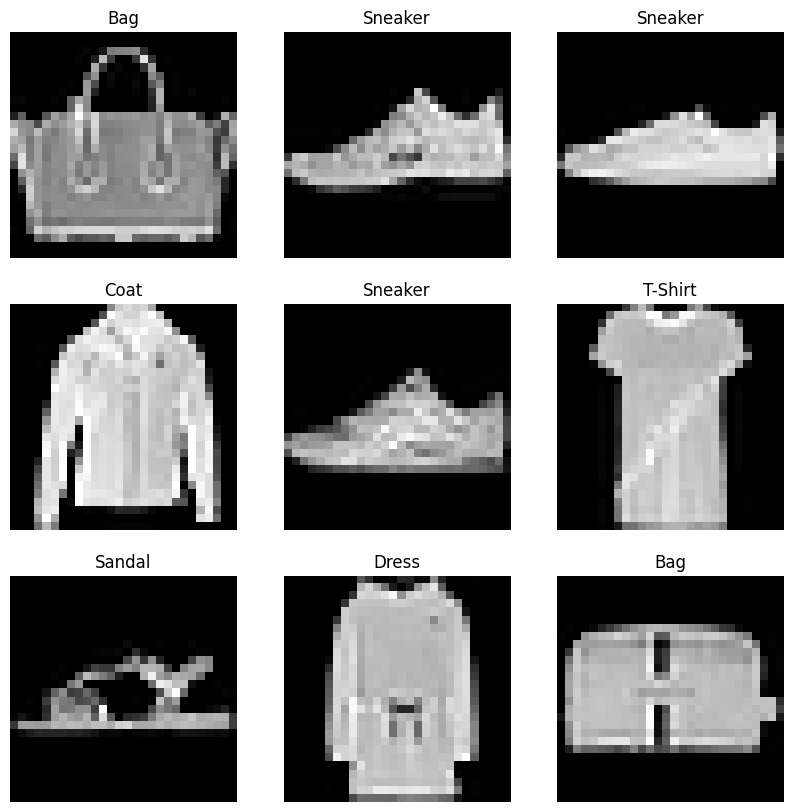

In [ ]:
val2label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(val2label[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Create a training and test `Dataloader` using your Datasets. You can use the same parameters as in our MNIST example or experiment for example with a different batch size.

In [ ]:
#hyperparameters

batch_size = 32
epochs = 10
learning_rate = 1e-3

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Create your training device, depending on GPU availability.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Now we can start to build our neural network by subclassing the `nn.Module`. Initialize the neural network layers in `__init__` and implement the `forward` method. As starting point, you can use the same parameters (number of layers, activation functions, number of neurons, etc.) as in our MNIST example.

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

Create an instance of your neural network, and move it to the chosen device.

In [ ]:
model = NN().to(device)

Check if your forward pass works, by passing a batch sample images from your training Dataloader. Remember to invoke your model's `__call__` method and **not** use the `forward` method.

``` python
logits = model(X)
```



In [ ]:
img, label = next(iter(train_dataloader))

img = img.to(device)
logits = model(img)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

print(f"Predicted class: {y_pred}")

Predicted class: tensor([8, 8, 8, 1, 1, 8, 1, 4, 1, 8, 4, 8, 8, 8, 8, 8, 1, 1, 1, 4, 4, 8, 8, 4,
        4, 8, 8, 8, 8, 5, 1, 1], device='cuda:0')


Define your hyperparameters (batch size, learning rate, epochs). As starting point you can use the same values used in the MNIST example.

In [ ]:
# done earlier

Initialize your loss function, we will use the  cross entropy loss function (`nn.CrossEntropyLoss`) in this example.

In [ ]:
loss_fn = nn.CrossEntropyLoss()

Initialize your optimization algorithm, we will use Stochastic Gradient Descent (`torch.optim.SGD`) for now.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Write your training loop.

* Remember to push your tensors to the right device
* Use all three steps neccessary for the backpropagation of the prediction loss

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Write your validation loop. Remember to call the `torch.no_grad()` method to avoid the computation of unneccessary gradients.

In [ ]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Train your model!

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302820  [   32/60000]
loss: 2.285332  [ 3232/60000]
loss: 2.279485  [ 6432/60000]
loss: 2.273492  [ 9632/60000]
loss: 2.252204  [12832/60000]
loss: 2.221309  [16032/60000]
loss: 2.197231  [19232/60000]
loss: 2.193277  [22432/60000]
loss: 2.200382  [25632/60000]
loss: 2.172476  [28832/60000]
loss: 2.148525  [32032/60000]
loss: 2.131363  [35232/60000]
loss: 2.093072  [38432/60000]
loss: 2.077740  [41632/60000]
loss: 2.057790  [44832/60000]
loss: 2.048048  [48032/60000]
loss: 1.922538  [51232/60000]
loss: 1.937693  [54432/60000]
loss: 1.929453  [57632/60000]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.872155 

Epoch 2
-------------------------------
loss: 1.857927  [   32/60000]
loss: 1.843652  [ 3232/60000]
loss: 1.822218  [ 6432/60000]
loss: 1.705025  [ 9632/60000]
loss: 1.616119  [12832/60000]
loss: 1.718315  [16032/60000]
loss: 1.544123  [19232/60000]
loss: 1.449396  [22432/60000]
loss: 1.625787  [25632/60000]
loss: 1.492548  [28832/60000

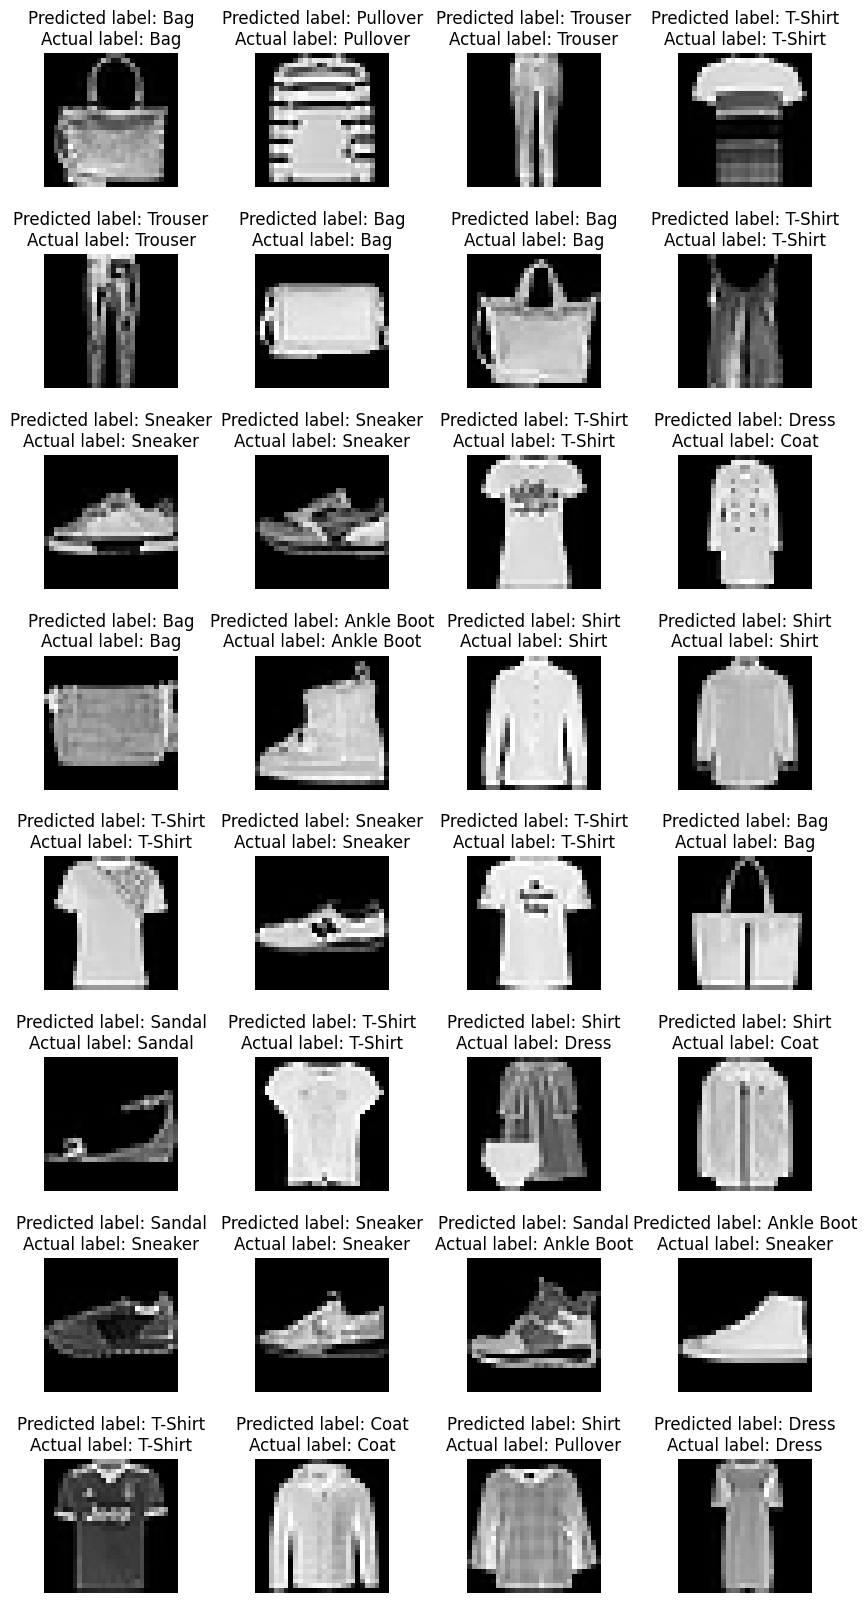

In [ ]:
img, label = next(iter(test_dataloader))
img = img.to(device)
label = label.to(device)
predicted_label = model(img)

figure = plt.figure(figsize=(10, 20))
cols, rows = 4, 8
for i in range(0, cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Predicted label: {val2label[predicted_label[i].argmax().item()]}\nActual label: {val2label[label[i].item()]}")
    plt.axis("off")
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(img[i].cpu().squeeze(), cmap="gray")
plt.show()

<Axes: >

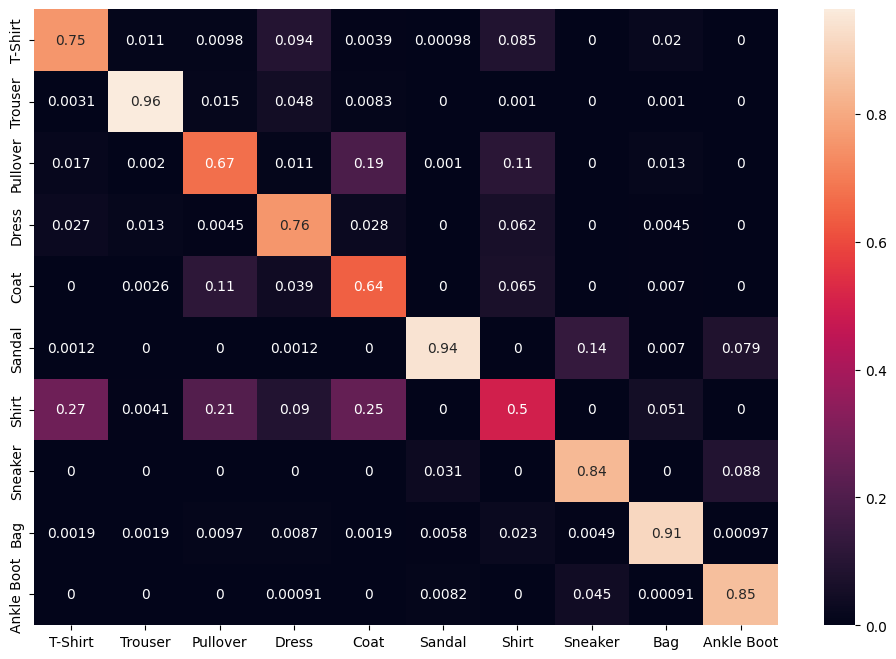

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)
            output = model(X)

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0)[:, None], index = [val2label[i] for i in range(10)],
                     columns = [val2label[i] for i in range(10)])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True)

If everything worked out fine, write down your best achieved results on the test set. Feel free to experiment with your model. For example you can try to

* change your hyperparameters - How does a change in batch size, learning rate, or number of epochs effect the performance of your model?
* change your model architecture - How does your model perform if you add additional hidden layers (don't forget the activation function!) or you increase/decrease the number of neurons per layer?
* change the optimization algorithm - Try to use the ADAM ([torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam)) optimization algorithm instead of SGD.
* identify which classes are hard to distinguish for the model, by plotting a confusion matrix.